In [1]:
import argparse
import os
import sys
import random
import time
import re
from dataclasses import dataclass
from distutils.util import strtobool
from typing import Any, List, Optional, Union, Tuple, Iterable
import gym
import numpy as np
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from numpy.random import Generator
import gym.envs.registration
import pandas as pd
from utils_previous_day import make_env
import utils

MAIN = __name__ == "__main__"
os.environ["SDL_VIDEODRIVER"] = "dummy"

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/tensorboard/compat/proto/histogram_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/tensorboard/compat/proto/histogram_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
/Users/jo

In [2]:
class QNetwork(nn.Module):
    def __init__(self, dim_observation: int, num_actions: int, hidden_sizes: list[int] = [120, 84]):
        super().__init__()
        self.dim_observation = dim_observation
        self.num_actions = num_actions
        self.hidden_sizes = hidden_sizes

        self.linear1 = nn.Linear(dim_observation, hidden_sizes[0])
        self.linear2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.linear3 = nn.Linear(hidden_sizes[1], self.num_actions)



    def forward(self, x: t.Tensor) -> t.Tensor:
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

if MAIN:
    net = QNetwork(dim_observation=4, num_actions=2)
    n_params = sum((p.nelement() for p in net.parameters()))
    print(net)
    print(f"Total number of parameters: {n_params}")
    print("You should manually verify network is Linear-ReLU-Linear-ReLU-Linear")
    assert n_params == 10934, n_params

QNetwork(
  (linear1): Linear(in_features=4, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=2, bias=True)
)
Total number of parameters: 10934
You should manually verify network is Linear-ReLU-Linear-ReLU-Linear


In [3]:
@dataclass
class ReplayBufferSamples:
    '''
    Samples from the replay buffer, converted to PyTorch for use in neural network training.
    obs: shape (sample_size, *observation_shape), dtype t.float
    actions: shape (sample_size, ) dtype t.int
    rewards: shape (sample_size, ), dtype t.float
    dones: shape (sample_size, ), dtype t.bool
    next_observations: shape (sample_size, *observation_shape), dtype t.float
    '''

    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor


class ReplayBuffer:
    rng: Generator
    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor

    def __init__(self, buffer_size: int, num_actions: int, observation_shape: tuple, num_environments: int, seed: int):
        assert num_environments == 1, "This buffer only supports SyncVectorEnv with 1 environment inside."
        self.seed = seed
        self.buffer_size = buffer_size
        self.num_actions = num_actions
        self.observation_shape = observation_shape

        self.observations = t.empty((0, *observation_shape), dtype=t.float)
        self.actions = t.empty((0, ), dtype=t.int)
        self.rewards = t.empty((0, ), dtype=t.float)
        self.dones = t.empty((0, ), dtype=t.bool)
        self.next_observations = t.empty((0, *observation_shape), dtype=t.float)

        self.rng = np.random.default_rng(seed)
        self.full = False

    def add(
        self, obs: np.ndarray, actions: np.ndarray, rewards: np.ndarray, dones: np.ndarray, next_obs: np.ndarray
    ) -> None:
        '''
        obs: shape (num_environments, *observation_shape) 
            Observation before the action
        actions: shape (num_environments, ) 
            Action chosen by the agent
        rewards: shape (num_environments, ) 
            Reward after the action
        dones: shape (num_environments, ) 
            If True, the episode ended and was reset automatically
        next_obs: shape (num_environments, *observation_shape) 
            Observation after the action
            If done is True, this should be the terminal observation, NOT the first observation of the next episode.
        '''

        # convert all inputs to int 
        obs = obs.astype(float)
        actions = actions.astype(int)
        rewards = rewards.astype(float)
        dones = dones.astype(bool)
        next_obs = next_obs.astype(float)

        if len(self.observations) < self.buffer_size:
            self.observations = t.cat((self.observations, t.Tensor(obs)))
            self.actions = t.cat((self.actions, t.Tensor(actions).to(t.int64)))
            self.rewards = t.cat((self.rewards, t.Tensor(rewards)))
            self.dones = t.cat((self.dones, t.Tensor(dones).to(t.bool)))
            self.next_observations = t.cat((self.next_observations, t.Tensor(next_obs))) 
        else:
            self.observations = t.cat((self.observations[1:], t.Tensor(obs)))
            self.actions = t.cat((self.actions[1:], t.Tensor(actions)))
            self.rewards = t.cat((self.rewards[1:], t.Tensor(rewards)))
            self.dones = t.cat((self.dones[1:], t.Tensor(dones)))
            self.next_observations = t.cat((self.next_observations[1:], t.Tensor(next_obs)))
        
        if len(self.observations) == self.buffer_size:
            self.full =True

    def sample(self, sample_size: int, device: t.device) -> ReplayBufferSamples:
        '''Uniformly sample sample_size entries from the buffer and convert them to PyTorch tensors on device.
        Sampling is with replacement, and sample_size may be larger than the buffer size.
        '''
        if not self.full:
            sample_size = len(self.observations)
            indices = self.rng.choice(len(self.observations), size=sample_size, replace=True)
        else:
            indices = self.rng.choice(len(self.observations), size=sample_size, replace=True)
        
        return ReplayBufferSamples(
            observations=self.observations[indices].to(device),
            actions=self.actions[indices].to(device),
            rewards=self.rewards[indices].to(device),
            dones=self.dones[indices].to(device),
            next_observations=self.next_observations[indices].to(device),
        )
t.set_default_dtype(t.float64)
if MAIN:
    utils.test_replay_buffer_single(ReplayBuffer)
    utils.test_replay_buffer_deterministic(ReplayBuffer)
    utils.test_replay_buffer_wraparound(ReplayBuffer)

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/vector/v

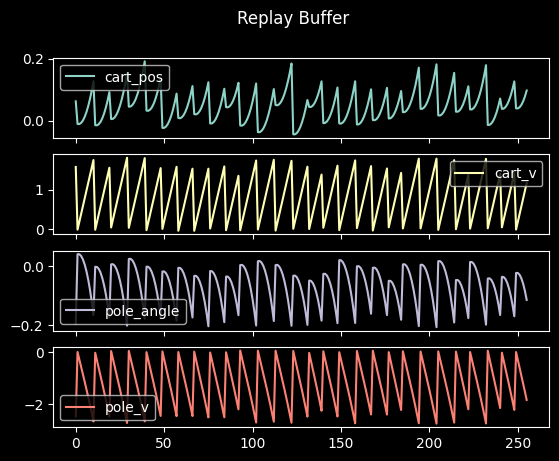

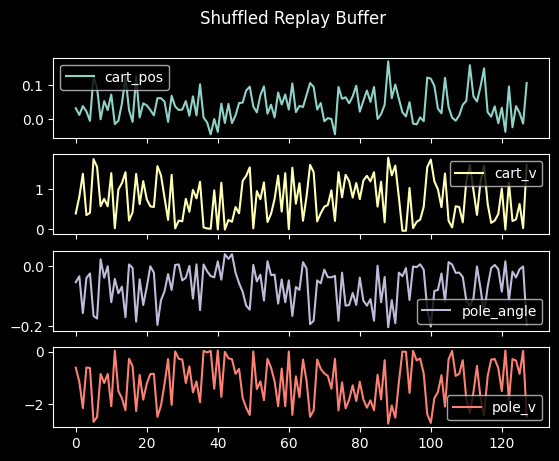

In [13]:
if MAIN:
    rb = ReplayBuffer(buffer_size=256, num_actions=2, observation_shape=(4,), num_environments=1, seed=0)
    envs = gym.vector.SyncVectorEnv([utils.make_env("CartPole-v1", 0, 0, False, "test")])
    obs = envs.reset(seed=3)
    for i in range(512):
        actions = np.array([1])
        (next_obs, rewards, dones, infos) = envs.step(actions)
        # real_next_obs = next_obs.copy()
        # for (i, done) in enumerate(dones):
        #     if done:
        #         real_next_obs[i] = infos[i]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, next_obs)
        obs = next_obs
    sample = rb.sample(128, t.device("cpu"))
    
    columns = ["cart_pos", "cart_v", "pole_angle", "pole_v"]
    df = pd.DataFrame(rb.observations, columns=columns)
    df.plot(subplots=True, title="Replay Buffer")
    df2 = pd.DataFrame(sample.observations, columns=columns)
    df2.plot(subplots=True, title="Shuffled Replay Buffer")

In [15]:
def linear_schedule(
    current_step: int, start_e: float, end_e: float, exploration_fraction: float, total_timesteps: int
) -> float:
    '''Return the appropriate epsilon for the current step.

    Epsilon should be start_e at step 0 and decrease linearly to end_e at step (exploration_fraction * total_timesteps).

    It should stay at end_e for the rest of the episode.
    '''
    if current_step < exploration_fraction * total_timesteps:
        return start_e - (start_e - end_e) * current_step / (exploration_fraction * total_timesteps)
    else:
        return end_e


if MAIN:
    epsilons = [
        linear_schedule(step, start_e=1.0, end_e=0.05, exploration_fraction=0.5, total_timesteps=500)
        for step in range(500)
    ]
    utils.test_linear_schedule(linear_schedule)

In [28]:
def epsilon_greedy_policy(
    envs: gym.vector.SyncVectorEnv, q_network: QNetwork, rng: Generator, obs: t.Tensor, epsilon: float
) -> np.ndarray:
    '''With probability epsilon, take a random action. Otherwise, take a greedy action according to the q_network.
    Inputs:
        envs : gym.vector.SyncVectorEnv, the family of environments to run against
        q_network : QNetwork, the network used to approximate the Q-value function
        obs : The current observation
        epsilon : exploration percentage
    Outputs:
        actions: (n_environments, ) the sampled action for each environment.
    '''
    pivot = rng.random()
    if pivot > epsilon:
        return np.argmax(q_network(obs).detach().numpy(), -1)
    else:
        return np.array(rng.choice(envs.single_action_space.n, size=(envs.num_envs,)))

if MAIN:
    utils.test_epsilon_greedy_policy(epsilon_greedy_policy)

In [29]:
ObsType = np.ndarray
ActType = int

class Probe1(gym.Env):
    '''One action, observation of [0.0], one timestep long, +1 reward.

    We expect the agent to rapidly learn that the value of the constant [0.0] observation is +1.0. Note we're using a continuous observation space for consistency with CartPole.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.seed()
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        return (np.array([0]), 1.0, True, {})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        if return_info:
            return (np.array([0.0]), {})
        return np.array([0.0])

gym.envs.registration.register(id="Probe1-v0", entry_point=Probe1)
if MAIN:
    env = gym.make("Probe1-v0")
    assert env.observation_space.shape == (1,)
    assert env.action_space.shape == ()



/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Probe1-v0
  logger.warn(f"Overriding environment {spec.id}")
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:45: UserWarning: WARN: A Box observation space maximum and minimum values are equal.
  logger.warn("A Box observation space maximum and minimum values are equal.")


In [32]:
class Probe2(gym.Env):
    '''One action, observation of [-1.0] or [+1.0], one timestep long, reward equals observation.

    We expect the agent to rapidly learn the value of each observation is equal to the observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.seed()
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        return (np.array([0]), np.array([self.reward]), True, {})


    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        self.reward = (random.rand() > 0.5)*2-1
        if return_info:
            return (np.array([self.reward]), {})
        return np.array([self.reward])


gym.envs.registration.register(id="Probe2-v0", entry_point=Probe2)

class Probe3(gym.Env):
    '''One action, [0.0] then [1.0] observation, two timesteps, +1 reward at the end.

    We expect the agent to rapidly learn the discounted value of the initial observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.seed()
        self.reset()
        self.observation = (random.rand() > 0.5)*2-1
        


    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        self.n+=1
        if self.n == 1:
            return (np.array([1.0]), 0.0, False, {})
        if self.steps == 1: 
            return (np.array([0]), 1.0, True, {})
        raise ValueError(self.n)
        


    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed = seed)
        self.n =0
        if return_info:
            return np.array([0.0]), {}
        return np.array([0.0])


gym.envs.registration.register(id="Probe3-v0", entry_point=Probe3)

class Probe4(gym.Env):
    '''Two actions, [0.0] observation, one timestep, reward is -1.0 or +1.0 dependent on the action.

    We expect the agent to learn to choose the +1.0 action.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe4-v0", entry_point=Probe4)

class Probe5(gym.Env):
    '''Two actions, random 0/1 observation, one timestep, reward is 1 if action equals observation otherwise -1.

    We expect the agent to learn to match its action to the observation.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        pass

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        pass

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        pass

gym.envs.registration.register(id="Probe5-v0", entry_point=Probe5)

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Probe2-v0
  logger.warn(f"Overriding environment {spec.id}")
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Probe3-v0
  logger.warn(f"Overriding environment {spec.id}")
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Probe4-v0
  logger.warn(f"Overriding environment {spec.id}")
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment Probe5-v0
  logger.warn(f"Overriding environment {spec.id}")


In [34]:
@dataclass
class DQNArgs:
    exp_name: str = os.path.basename(globals().get("__file__", "DQN_implementation").rstrip(".py"))
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = False
    wandb_project_name: str = "CartPoleDQN"
    wandb_entity: Optional[str] = None
    capture_video: bool = False
    env_id: str = "CartPole-v1"
    total_timesteps: int = 500000
    learning_rate: float = 0.00025
    buffer_size: int = 10000
    gamma: float = 0.99
    target_network_frequency: int = 500
    batch_size: int = 128
    start_e: float = 1.0
    end_e: float = 0.05
    exploration_fraction: float = 0.5
    learning_starts: int = 10000
    train_frequency: int = 10

arg_help_strings = dict(
    exp_name = "the name of this experiment",
    seed = "seed of the experiment",
    torch_deterministic = "if toggled, `torch.backends.cudnn.deterministic=False`",
    cuda = "if toggled, cuda will be enabled by default",
    track = "if toggled, this experiment will be tracked with Weights and Biases",
    wandb_project_name = "the wandb's project name",
    wandb_entity = "the entity (team) of wandb's project",
    capture_video = "whether to capture videos of the agent performances (check out `videos` folder)",
    env_id = "the id of the environment",
    total_timesteps = "total timesteps of the experiments",
    learning_rate = "the learning rate of the optimizer",
    buffer_size = "the replay memory buffer size",
    gamma = "the discount factor gamma",
    target_network_frequency = "the timesteps it takes to update the target network",
    batch_size = "the batch size of samples from the replay memory",
    start_e = "the starting epsilon for exploration",
    end_e = "the ending epsilon for exploration",
    exploration_fraction = "the fraction of `total-timesteps` it takes from start-e to go end-e",
    learning_starts = "timestep to start learning",
    train_frequency = "the frequency of training",
)
toggles = ["torch_deterministic", "cuda", "track", "capture_video"]

def parse_args(arg_help_strings=arg_help_strings, toggles=toggles) -> DQNArgs:
    parser = argparse.ArgumentParser()
    for (name, field) in DQNArgs.__dataclass_fields__.items():
        flag = "--" + name.replace("_", "-")
        type_function = field.type if field.type != bool else lambda x: bool(strtobool(x))
        toggle_kwargs = {"nargs": "?", "const": True} if name in toggles else {}
        parser.add_argument(
            flag, type=type_function, default=field.default, help=arg_help_strings[name], **toggle_kwargs
        )
    return DQNArgs(**vars(parser.parse_args()))

def setup(args: DQNArgs) -> Tuple[str, SummaryWriter, np.random.Generator, t.device, gym.vector.SyncVectorEnv]:
    '''Helper function to set up useful variables for the DQN implementation'''
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % "\n".join([f"|{key}|{value}|" for (key, value) in vars(args).items()]),
    )
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    rng = np.random.default_rng(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv([utils.make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, Discrete), "only discrete action space is supported"
    return (run_name, writer, rng, device, envs)

def log(
    writer: SummaryWriter,
    start_time: float,
    step: int,
    predicted_q_vals: t.Tensor,
    loss: Union[float, t.Tensor],
    infos: Iterable[dict],
    epsilon: float,
):
    '''Helper function to write relevant info to TensorBoard logs, and print some things to stdout'''
    if step % 100 == 0:
        writer.add_scalar("losses/td_loss", loss, step)
        writer.add_scalar("losses/q_values", predicted_q_vals.mean().item(), step)
        writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)), step)
        if step % 10000 == 0:
            print("SPS:", int(step / (time.time() - start_time)))
    for info in infos:
        if "episode" in info.keys():
            print(f"global_step={step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], step)
            writer.add_scalar("charts/epsilon", epsilon, step)
            break

python <your-script>.py -h

python <your-script>.py --track --capture-video

In [51]:
def train_dqn(args: DQNArgs):
    (run_name, writer, rng, device, envs) = setup(args)
    "YOUR CODE: Create your Q-network, Adam optimizer, and replay buffer here."

    obs_shape = envs.observation_space.shape[-1]
    num_actions = envs.single_action_space.n
    q_network = QNetwork(obs_shape, num_actions)
    optimizer = optim.Adam(q_network.parameters(), args.learning_rate)
    replay_buffer = ReplayBuffer(args.buffer_size, num_actions, num_environments=len(envs.envs))

    start_time = time.time()
    obs = envs.reset()
    for step in range(args.total_timesteps):
        "YOUR CODE: Sample actions according to the epsilon greedy policy using the linear schedule for epsilon, and then step the environment"

        epsilon = linear_schedule(step, args.start_e, args.end_e, exploration_fraction=args.exploration_fraction, total_timesteps=args.total_timesteps)
        actions = epsilon_greedy_policy(envs, q_network, rng, obs, epsilon)
        (next_obs, rewards, dones, infos) = envs.step(actions)

        rb.add(obs, actions, rewards, dones, next_obs)
        obs = next_obs
        if step > args.learning_starts and step % args.train_frequency == 0:
            "YOUR CODE: Sample from the replay buffer, compute the TD target, compute TD loss, and perform an optimizer step."

            samples = replay_buffer.sample(args.batch_size, device = device)

            with t.inference_mode:
                predicted_q_vals = q_network(samples.next_observations)
                y = samples.rewards+args.gamma*torch.argmax(predicted_q_vals)
            loss = ((y - q_network(samples.observations))**2).sum()/args.batch_size

            q_network.zero_grad()            
            loss.backward()
            optimizer.step()

            log(writer, start_time, step, predicted_q_vals, loss, infos, epsilon)

    "If running one of the Probe environments, will test if the learned q-values are\n    sensible after training. Useful for debugging."
    probe_batches = [
        t.tensor([[0.0]]), t.tensor([[-1.0], [+1.0]]), t.tensor([[0.0], [1.0]]), t.tensor([[0.0]]), t.tensor([[0.0], [1.0]])
    ]
    if re.match(r"Probe(\d)-v0", args.env_id):
        probe_no = int(re.match(r"Probe(\d)-v0", args.env_id).group(1))
        batch = probe_batches[probe_no]
        value = q_network(batch)
        print("Value: ", value)
        expected = t.tensor([[1.0]]).to(device)
        t.testing.assert_close(value, expected, 0.0001)

    envs.close()
    writer.close()